# CNN Development

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import regularizers
from keras import optimizers
from tensorflow.python.client import device_lib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import numpy as np
import pandas as pd
import os
import librosa
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_pkl(data, path):
    with open(path, "wb") as saved_data:
        pickle.dump(data, saved_data)
    saved_data.close()

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return

## Feature Extraction

In [3]:
data_info = pd.read_csv("C:\\tmp\\sound_datasets\\urbansound8k\\metadata\\UrbanSound8K.csv")
data_info

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [4]:
FOLDS_PATH = "C:/tmp/sound_datasets/urbansound8k/audio"
DURATION = 4 # 4 seconds for each audio file
SAMPLE_RATE = 22050
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1

In [5]:
def zero_pad(audio_file_path):
    signal, sample_rate = librosa.load(audio_file_path, sr=None)
    # resample the sample rate to the target value of SR
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=SAMPLE_RATE)
    # zero padding
    if len(signal) < DURATION*SAMPLE_RATE:
        signal = np.concatenate([
            signal,
            np.zeros(shape=(DURATION*SAMPLE_RATE - len(signal), ))
        ])
    elif len(signal) > DURATION*SAMPLE_RATE:
        signal = signal[:DURATION*SAMPLE_RATE]
    return signal

In [6]:
folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
df_data = []
if not os.path.exists("C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl"):
    for fold in folds:
        i = 0
        print(fold)
        audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
        for audio in audio_files:
            classid = data_info[data_info["slice_file_name"]
                                == audio.split("\\")[-1]]["classID"].values[0]

            inpt = zero_pad(audio)

            mel_spec = librosa.feature.melspectrogram(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # print(mel_spec.shape)
            #plt.figure(figsize=(10, 4))
            #plt.imshow(mel_spec, cmap='hot')
            # plt.show()
            choom = librosa.feature.chroma_stft(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_chroma=121)
            # print(choom.shape)
            flt = librosa.feature.spectral_flatness(
                y=inpt, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            bdw = librosa.feature.spectral_bandwidth(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            rol = librosa.feature.spectral_rolloff(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            cen = librosa.feature.spectral_centroid(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            extract = {
                "fold": fold,
                "mel_spec": mel_spec,
                "chroma": choom,
                "spectral_flatness": flt,
                "spectral_bandwidth": bdw,
                "spectral_rolloff": rol,
                "spectral_centroid": cen,
                "target": int(classid)
            }
            if i % 10 == 0:
                print(str(i) + " audios processed out of " +
                      str(len(audio_files)))
            df_data.append(extract)
            i += 1

    df_data = pd.DataFrame(df_data, columns=["fold", "mel_spec", "chroma", "spectral_flatness",
                           "spectral_bandwidth", "spectral_rolloff", "spectral_centroid", "target"])
    ohe_targets = np.zeros(
        shape=(df_data['target'].size, df_data['target'].max()+1))
    ohe_targets[np.arange(df_data['target'].size),
                df_data['target'].to_numpy(dtype=np.int16)] = 1
    df_data['target'] = ohe_targets.tolist()
    df_data['target'].apply(np.array)

    save_pkl(
        df_data, "C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl")
else:
    df_data = load_pkl(
        "C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl")


fold1
0 audios processed out of 873
10 audios processed out of 873
20 audios processed out of 873
30 audios processed out of 873
40 audios processed out of 873
50 audios processed out of 873
60 audios processed out of 873
70 audios processed out of 873
80 audios processed out of 873
90 audios processed out of 873
100 audios processed out of 873
110 audios processed out of 873
120 audios processed out of 873
130 audios processed out of 873
140 audios processed out of 873
150 audios processed out of 873
160 audios processed out of 873
170 audios processed out of 873
180 audios processed out of 873
190 audios processed out of 873
200 audios processed out of 873
210 audios processed out of 873
220 audios processed out of 873
230 audios processed out of 873
240 audios processed out of 873
250 audios processed out of 873
260 audios processed out of 873
270 audios processed out of 873
280 audios processed out of 873
290 audios processed out of 873
300 audios processed out of 873
310 audios pr

### Features & Shapes:

- 2D Chromagram: (121, 320)
- 2D Mel Spectogram: (128, 320)
- 1D Features: (320)

In [16]:
mel_shape = (128,320, 1)
chroma_shape = (121,320, 1)
oned_shape = (320,4)

## Model Creation

In [21]:
def create_model():

  melinput = layers.Input(shape=mel_shape, name = 'mel_spectogram_input')

  mel = layers.Conv2D(16,kernel_size=7,strides=2,padding="Same",activation="relu", kernel_initializer='he_normal')(melinput)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Conv2D(64,kernel_size=3,strides=1,padding="Same",activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Conv2D(128,kernel_size=3,strides=1,padding="Same",activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Flatten()(mel)

  chromainput = layers.Input(shape=chroma_shape, name = 'chromagram_input')

  chroma = layers.Conv2D(16,kernel_size=5,strides=1,padding="valid",activation="relu", kernel_initializer='he_normal')(chromainput)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(32,kernel_size=5,strides=1,padding="valid",activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(64,kernel_size=3,strides=1,padding="valid",activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(128,kernel_size=3,strides=1,padding="valid",activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Flatten()(chroma)

  onedinput = layers.Input(shape=oned_shape, name = 'one_d_input')

  oned = layers.Conv1D(16,kernel_size=5,strides=1,activation="relu")(onedinput)
  oned = layers.MaxPooling1D(padding='same',pool_size=(2))(oned)
  oned = layers.Dropout(0.2)(oned)
  oned = layers.Conv1D(32,kernel_size=3,strides=1,activation="relu")(oned)
  oned = layers.MaxPooling1D(pool_size=(2))(oned)
  oned = layers.Dropout(0.2)(oned)
  oned = layers.Conv1D(64,kernel_size=3,strides=1,activation="relu")(oned)
  oned = layers.Flatten()(oned) 

  combined = layers.concatenate([mel, chroma, oned])

  combined = layers.Dense(512,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)
  combined = layers.Dropout(0.2)(combined)
  combined = layers.Dense(512,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)
  combined = layers.Dropout(0.2)(combined)
  combined = layers.Dense(256,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)

  output = layers.Dense(10, activation='softmax')(combined)

  model = keras.Model(inputs=[melinput, chromainput, onedinput], outputs=[output])

  return model

In [22]:
model = create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_spectogram_input (Inpu  [(None, 128, 320, 1)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 160, 16)          800       ['mel_spectogram_input[0][0]']
                                                                                                  
 chromagram_input (InputLay  [(None, 121, 320, 1)]        0         []                            
 er)                                                                                              
                                                                                            

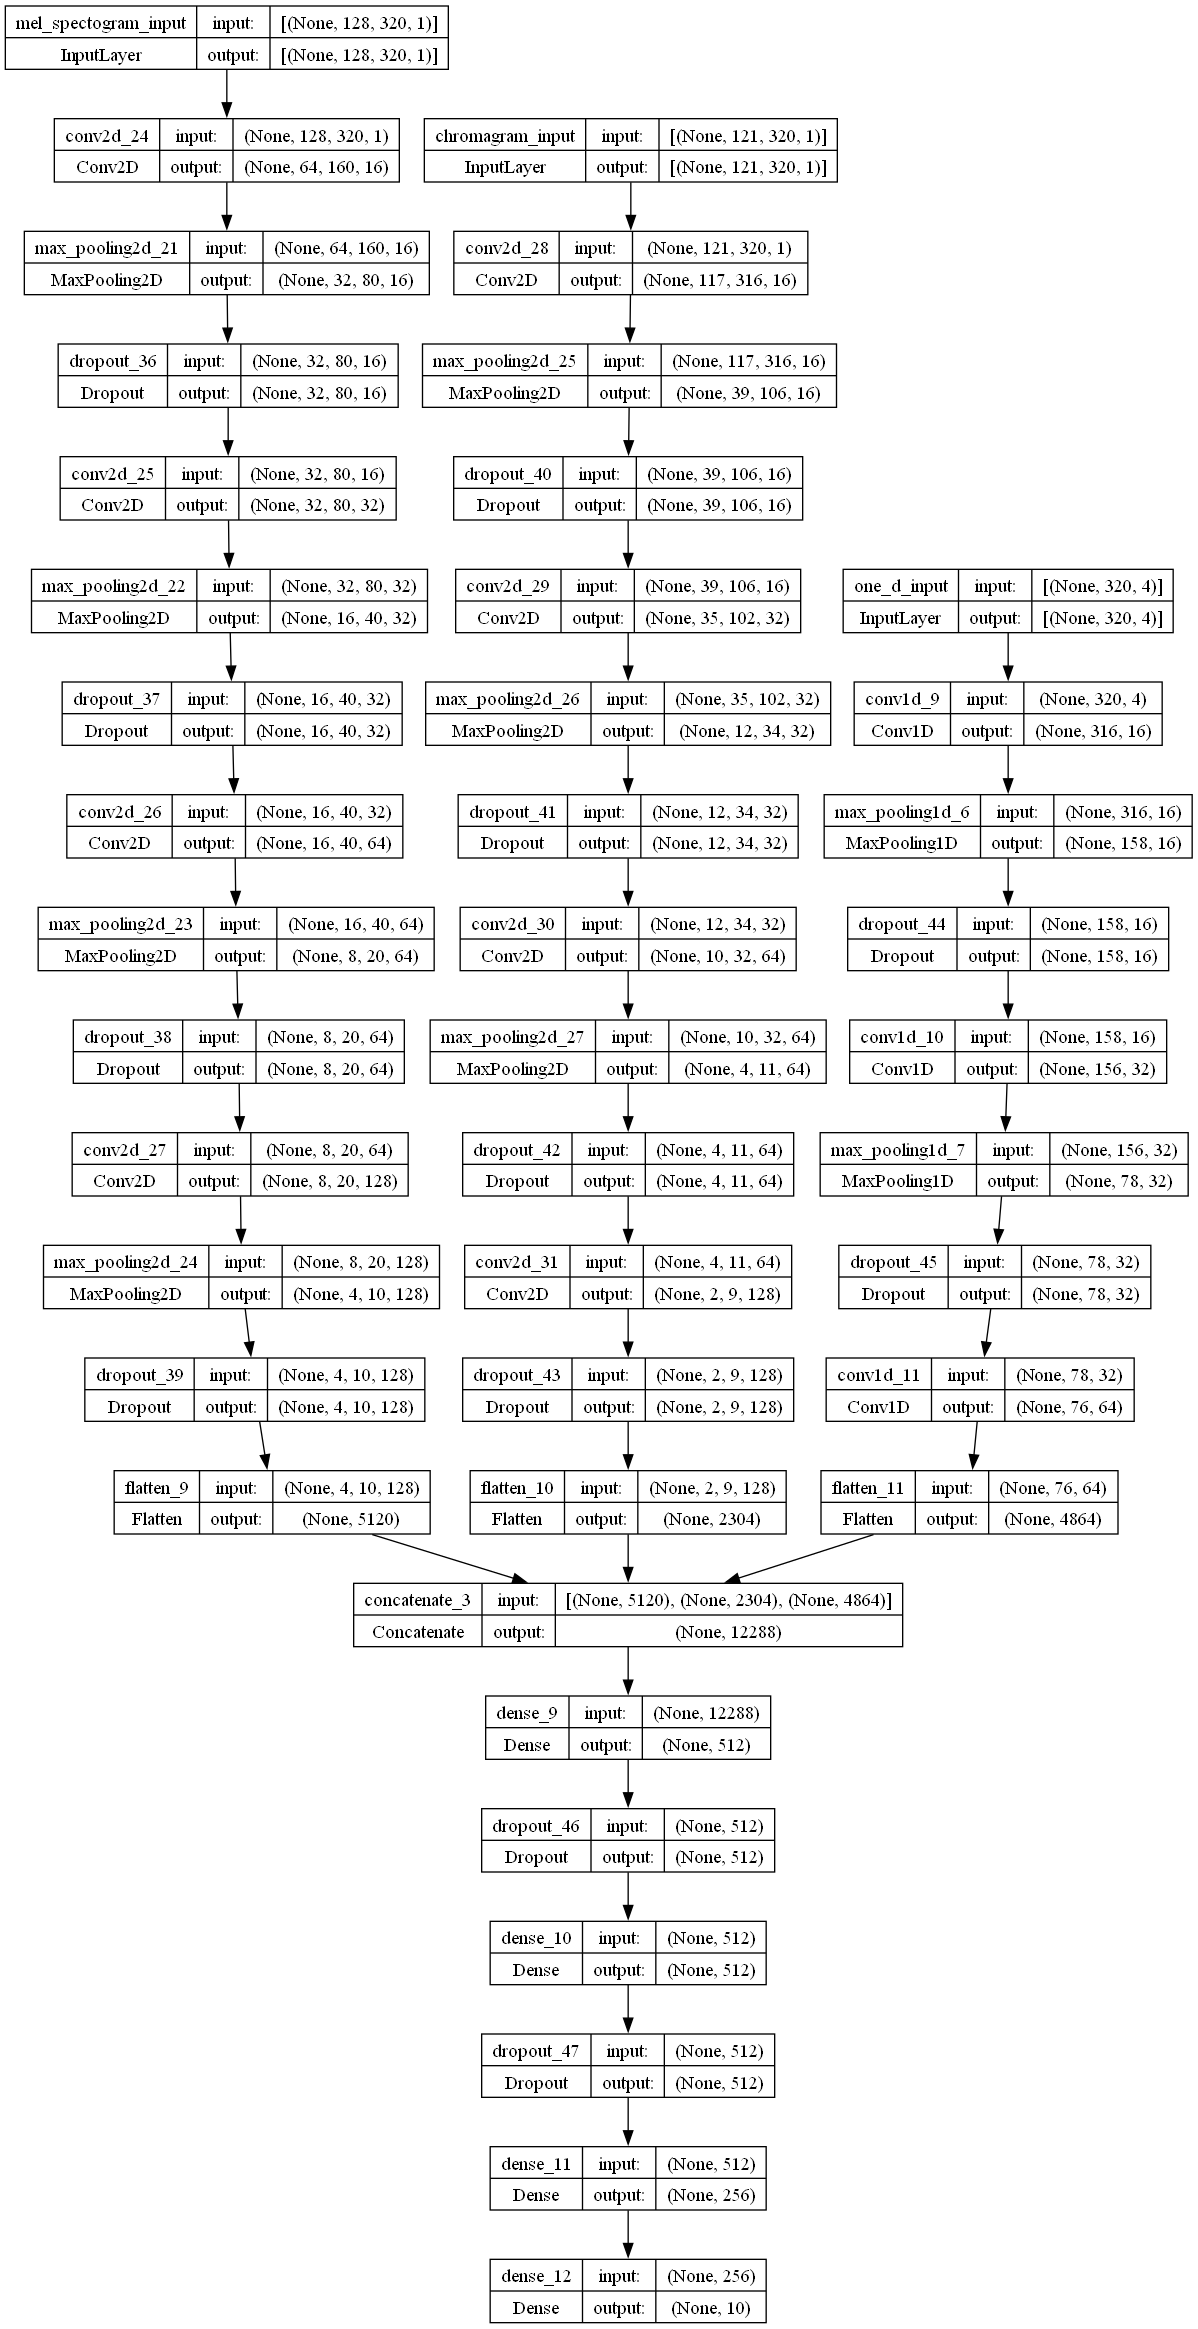

In [23]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Data Reshaping

In [24]:
def ready_data(fold):
    X_test = df_data[df_data["fold"] == fold]
    X_train = df_data[df_data["fold"] != fold]

    y_train = X_train["target"]
    X_train = X_train.drop(columns=["fold"])

    X_test, X_val, y_test, y_val = train_test_split(X_test.drop(columns=["fold"]), X_test["target"], test_size=0.5, random_state=42)

    X_train_mel = np.asarray(X_train["mel_spec"].to_list()).astype(np.float32)
    X_train_chroma = np.asarray(X_train["chroma"].to_list()).astype(np.float32)

    a = np.asarray(tuple(X_train["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_train["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_train["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_train["spectral_rolloff"].to_list())).astype(np.float32)

    X_train_1d = np.stack([a,b,c,d], axis=-1)
    X_train_1d = X_train_1d.reshape(-1, TIME_SIZE, 4)

    a = np.asarray(tuple(X_val["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_val["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_val["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_val["spectral_rolloff"].to_list())).astype(np.float32)

    X_val_1d = np.stack([a,b,c,d], axis=-1)
    X_val_1d = X_val_1d.reshape(-1, TIME_SIZE, 4)

    a = np.asarray(tuple(X_test["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_test["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_test["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_test["spectral_rolloff"].to_list())).astype(np.float32)

    X_test_1d = np.stack([a,b,c,d], axis=-1)
    X_test_1d = X_test_1d.reshape(-1, TIME_SIZE, 4) 

    X_val_mel = np.asarray(X_val["mel_spec"].to_list()).astype(np.float32)
    X_val_chroma = np.asarray(X_val["chroma"].to_list()).astype(np.float32)
    X_test_mel = np.asarray(X_test["mel_spec"].to_list()).astype(np.float32)
    X_test_chroma = np.asarray(X_test["chroma"].to_list()).astype(np.float32)
    y_train = np.asarray(y_train.to_list()).astype(np.float32)
    y_val = np.asarray(y_val.to_list()).astype(np.float32)	
    y_test = np.asarray(y_test.to_list()).astype(np.float32)

    del X_train
    del X_val
    del X_test
    del a
    del b
    del c
    del d

    return X_train_mel, X_train_chroma, X_train_1d, y_train, X_val_mel, X_val_chroma, X_val_1d, y_val, X_test_mel, X_test_chroma, X_test_1d, y_test

## Metric Variables

In [25]:
fold_metrics = []

## 10-Fold Cross Validation

In [26]:
for i in range(1,11):
    fold = "fold"+str(i)
    print("fold"+str(i))

    model = create_model()

    X_train_mel, X_train_chroma, X_train_1d, y_train, X_val_mel, X_val_chroma, X_val_1d, y_val, X_test_mel, X_test_chroma, X_test_1d, y_test = ready_data(fold)

    adam = optimizers.Adam(lr=0.0001)
    
    model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    a = model.fit(
        {'mel_spectogram_input': X_train_mel, 'chromagram_input': X_train_chroma, 'one_d_input': X_train_1d},
        validation_data=({'mel_spectogram_input': X_val_mel, 'chromagram_input': X_val_chroma, 'one_d_input': X_val_1d}, y_val),
        y = y_train,
        epochs=30,
        batch_size=128
    )

    # evaluation = model.evaluate(x={'features_1d': X_test_1d, 'chromagram': X_test_chroma, 'mel_spectogram_input': X_test_mel, 'fourier_tempogram': X_test_fourier}, y=y_test)
    # y_pred = model.predict(x={'features_1d': X_test_1d, 'chromagram': X_test_mel, 'mel_spectogram_input': X_test_mel, 'fourier_tempogram': X_test_fourier})

    evaluation = model.evaluate(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma, 'one_d_input': X_test_1d}, y=y_test)
    y_pred = model.predict(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma, 'one_d_input': X_test_1d})

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)

    m_metrics = {'loss': evaluation[0], 'accuracy': evaluation[1], 'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 'history': model, 'history_dict': a.history}
    fold_metrics.append(mmetrics)
    save_pkl(m_metrics, f"kfold_metrics/metrics_fold{i}.pkl")
    model.save(f"kfold_metrics/model_fold{i}.keras", save_format="keras")




fold1
Epoch 1/30
62/62 [==============================] - 43s 608ms/step - loss: 366.9987 - accuracy: 0.1225 - val_loss: 107.8182 - val_accuracy: 0.1968
Epoch 2/30
62/62 [==============================] - 37s 597ms/step - loss: 100.7890 - accuracy: 0.1669 - val_loss: 94.7946 - val_accuracy: 0.1693
Epoch 3/30
62/62 [==============================] - 37s 592ms/step - loss: 89.6693 - accuracy: 0.2037 - val_loss: 85.0294 - val_accuracy: 0.1922
Epoch 4/30
62/62 [==============================] - 37s 597ms/step - loss: 81.3302 - accuracy: 0.2172 - val_loss: 77.6610 - val_accuracy: 0.2059
Epoch 5/30
62/62 [==============================] - 38s 606ms/step - loss: 74.5131 - accuracy: 0.2463 - val_loss: 71.4333 - val_accuracy: 0.2517
Epoch 6/30
62/62 [==============================] - 39s 628ms/step - loss: 68.7907 - accuracy: 0.2704 - val_loss: 66.2249 - val_accuracy: 0.1922
Epoch 7/30
62/62 [==============================] - 37s 598ms/step - loss: 63.8941 - accuracy: 0.2778 - val_loss: 61.6631

FileNotFoundError: [Errno 2] No such file or directory: 'kfold_metrics/metrics_fold1.pkl'

## Model Analysis

### Accuracy & Loss 

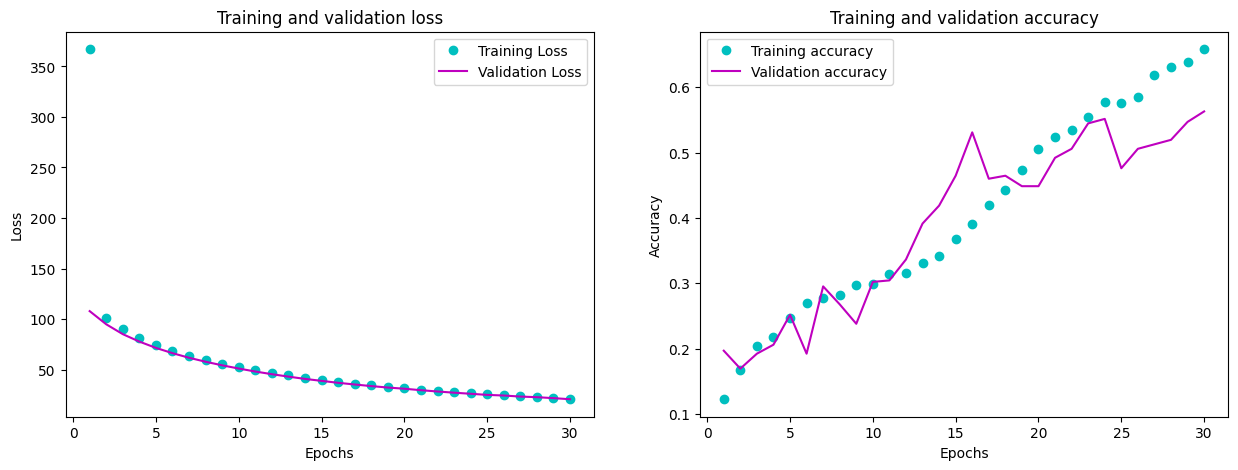

In [28]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
import matplotlib.pyplot as plt

history_dict = a.history

loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values = history_dict['val_accuracy']

epochs = range(1,31)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

### Confusion Matrix

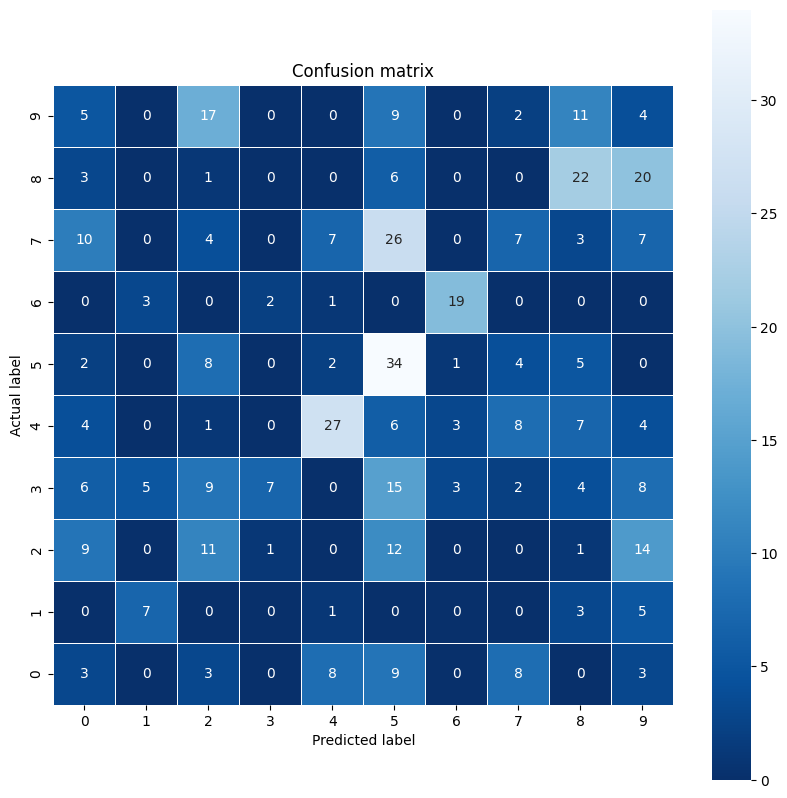

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test_reshape, y_pred_reshape)
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.invert_yaxis()
plt.title('Confusion matrix')
plt.show()
